In [21]:
import os 
import warnings

warnings.filterwarnings("ignore")
os.chdir("/Users/erjo3868/repos/hypedsearch/hypedsearch")
print(f"cwd = {os.getcwd()}")

from src.erik import load_comet_data
import numpy as np
from src.erik import (
    get_data_for_spectrum, 
    get_b_y_ion_sequences, 
    get_b_ion_sequences, 
    get_y_ion_sequences, 
    load_mzml_data,
    get_specific_spectrum,
    b_ion_neutral_mass,
    y_ion_neutral_mass,
    mass_difference_in_ppm
)
from src.erik_constants import SAMPLE, SCAN
from typing import Counter
from src.ryans_get_mass_code import calc_masses, b_ions
import seaborn as sns
from src.plot_utils import fig_setup, finalize, set_title_axes_labels

PMZ = "precursor_mz"
PC = "precursor_charge"
C = "charge"
ENM = "exp_neutral_mass"
XC = "xcorr"
PP = "plain_peptide"
PL = "peptide_len"
IM = "ions_matched"


cwd = /Users/erjo3868/repos/hypedsearch/hypedsearch


# Load Comet and spectra (MZML) data

In [4]:
# Load comet data
comet_df = load_comet_data()
comet_df.head(2)


Reading data for BMEM_AspN_Fxn4
Reading data for BMEM_AspN_Fxn5
Reading data for BMEM_AspN_Fxn6
Reading data for BMEM_AspN_Fxn7
Reading data for BMEM_AspN_Fxn8
Reading data for BMEM_AspN_Fxn9


,scan,num,charge,exp_neutral_mass,calc_neutral_mass,e-value,xcorr,delta_cn,sp_score,ions_matched,...,plain_peptide,modified_peptide,prev_aa,next_aa,protein,protein_count,modifications,retention_time_sec,sp_rank,sample
0,7,1,3,1525.774133,1525.773636,0.000202,2.187,0.4294,229.0,15,...,SAAPAAGSAPAAAEEKK,G.SAAPAAGSAPAAAEEKK.D,G,D,"tr|A0A5F8MPY2|A0A5F8MPY2_MOUSE,sp|P99027|RLA2_...",2,-,714.0,1,BMEM_AspN_Fxn4
1,7,2,3,1525.774133,1525.773636,2.030000,1.248,0.0200,26.0,6,...,AAQTPGSGEAVLSKNP,T.AAQTPGSGEAVLSKNP.N,T,N,sp|Q8BI84|TGO1_MOUSE,1,-,714.0,16,BMEM_AspN_Fxn4


In [ ]:
mzml_df = load_mzml_data()


# EDA

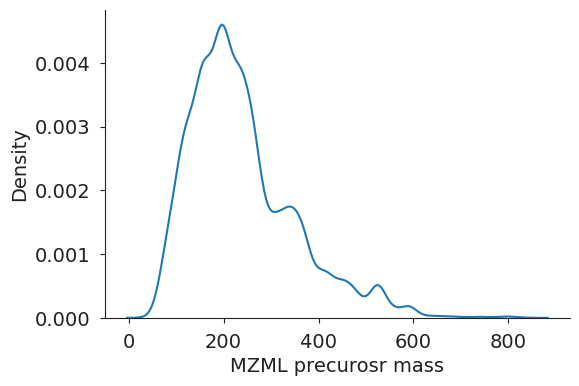

In [9]:
_, axs = fig_setup(1,1)
_=sns.kdeplot(data=(mzml_df[PMZ] / mzml_df[PC]) , ax=axs[0])
set_title_axes_labels(axs[0], xlabel="MZML precurosr mass", ylabel="Density")
finalize(axs)


# `exp_neutral_mass`

In [7]:
PMZ = "precursor_mz"
PC = "precursor_charge"
C = "charge"
ENM = "exp_neutral_mass"

# See if exp_neutral_mass makes sense
result = []
for group_name, group_df in comet_df.groupby(["sample", "scan"]):
    sample, scan_num = group_name[0], int(group_name[1])
    comet_exp_neut_mass = np.unique(group_df[ENM])
    assert (len(comet_exp_neut_mass) == 1)
    comet_exp_neut_mass = comet_exp_neut_mass[0]

    # Get precursor mass from MZML
    spectrum = mzml_df[(mzml_df[SCAN]==scan_num) & (mzml_df["mzml"] == f"{sample}.mzML")]
    assert spectrum.shape[0] == 1, "Should only be one matching spectrum"
    spectrum = spectrum.iloc[0]
    mzml_mass = spectrum[PC] * spectrum[PMZ]

    result.append(abs(mzml_mass - comet_exp_neut_mass))

    # For testing
    # sample, scan_num
    # break

In [8]:
Counter(result)

Counter({np.float64(2.014552999999978): 8181,
         np.float64(3.021829000000025): 2226,
         np.float64(2.0145530000000917): 821,
         np.float64(3.021828999999798): 533,
         np.float64(2.0145530000002054): 495,
         np.float64(3.0218290000002526): 209,
         np.float64(3.0218289999999115): 80,
         np.float64(3.021829000000139): 18,
         np.float64(2.0145529999998644): 3})

# `ions_matched`

In [5]:
# Sort so best spectrum-peptide matches are first
df = comet_df.sort_values(by="xcorr", ascending=False)
df.reset_index(inplace=True, drop=True)

# Add a peptide length column
df[PL] = df[PP].apply(lambda peptide: len(peptide))

# Look at first row
row = df.iloc[0]
seq = row[PP]

b_seqs = get_b_ion_sequences(peptide=seq)
y_seqs = get_y_ion_sequences(peptide=seq)
print(f"Seq = {seq} \n b-seqs:\n{b_seqs} \n y-seqs:\n{y_seqs}")

# Get spectrum
spectrum = get_specific_spectrum(sample=row["sample"], scan_num=row["scan"])
spectrum

Seq = YMVGPIEEAVAKA 
 b-seqs:
['Y', 'YM', 'YMV', 'YMVG', 'YMVGP', 'YMVGPI', 'YMVGPIE', 'YMVGPIEE', 'YMVGPIEEA', 'YMVGPIEEAV', 'YMVGPIEEAVA', 'YMVGPIEEAVAK', 'YMVGPIEEAVAKA'] 
 y-seqs:
['MVGPIEEAVAKA', 'VGPIEEAVAKA', 'GPIEEAVAKA', 'PIEEAVAKA', 'IEEAVAKA', 'EEAVAKA', 'EAVAKA', 'AVAKA', 'VAKA', 'AKA', 'KA', 'A']


Spectrum(peaks=[Peak(mz=np.float64(55.05408477783203), abundance=np.float64(87.14974975585938)), Peak(mz=np.float64(58.172611236572266), abundance=np.float64(29.048913955688477)), Peak(mz=np.float64(60.31646728515625), abundance=np.float64(56.90322494506836)), Peak(mz=np.float64(69.06951904296875), abundance=np.float64(124.37157440185547)), Peak(mz=np.float64(70.06513214111328), abundance=np.float64(2604.92724609375)), Peak(mz=np.float64(70.2379150390625), abundance=np.float64(37.235294342041016)), Peak(mz=np.float64(71.06824493408203), abundance=np.float64(367.9293518066406)), Peak(mz=np.float64(72.08072662353516), abundance=np.float64(1720.1806640625)), Peak(mz=np.float64(72.26895141601562), abundance=np.float64(99.03629302978516)), Peak(mz=np.float64(74.05962371826172), abundance=np.float64(67.55577087402344)), Peak(mz=np.float64(75.25961303710938), abundance=np.float64(80.46939086914062)), Peak(mz=np.float64(81.41719818115234), abundance=np.float64(52.36084747314453)), Peak(mz=np.f

In [25]:
# Loop over ions and find matching peak
ppm_tol = 10
charges_to_consider = [1, 2, 3]
matches = 0
matched_peaks = []

# b-ions
for peak_idx, peak in enumerate(spectrum.peaks):
    # print(f"peak = {peak}")
    for ion in b_seqs:
        # print(f"\t proposed ion = {ion}")
        for charge in charges_to_consider:
            # obs_mass = peak.mz * charge
            ion_mass = b_ion_neutral_mass(
                aa_seq=seq, charge=charge
            )
            ppm_diff = mass_difference_in_ppm(
                ref_mass=peak.mz,
                query_mass=ion_mass

            )
            if ppm_diff <= ppm_tol:
                matched_peaks.append(peak_idx)
                matches += 1
                # print("yay!")
            # print(f"\t\tcharge {charge}, ion mass {ion_mass} PPM diff = {ppm_diff}")
        # break
    # break

# y-ions
for peak_idx, peak in enumerate(spectrum.peaks):
    # print(f"peak = {peak}")
    for ion in y_seqs:
        # print(f"\t proposed ion = {ion}")
        for charge in charges_to_consider:
            # obs_mass = peak.mz * charge
            ion_mass = y_ion_neutral_mass(
                aa_seq=seq, charge=charge
            )
            ppm_diff = mass_difference_in_ppm(
                ref_mass=peak.mz,
                query_mass=ion_mass
            )
            if ppm_diff <= ppm_tol:
                matched_peaks.append(peak_idx)
                matches += 1

matches
len(matched_peaks)

13

13

In [24]:
spectrum.peaks[367]

Peak(mz=np.float64(453.90606689453125), abundance=np.float64(117.96491241455078))

In [24]:
seq = row[PP]
get_b_y_ion_sequences(peptide=seq)
get_b_ion_sequences(peptide=seq)
get_y_ion_sequences(peptide=seq)



# For testing
seq
row[IM]


['Y',
 'YM',
 'YMV',
 'YMVG',
 'YMVGP',
 'YMVGPI',
 'YMVGPIE',
 'YMVGPIEE',
 'YMVGPIEEA',
 'YMVGPIEEAV',
 'YMVGPIEEAVA',
 'YMVGPIEEAVAK',
 'YMVGPIEEAVAKA',
 'MVGPIEEAVAKA',
 'VGPIEEAVAKA',
 'GPIEEAVAKA',
 'PIEEAVAKA',
 'IEEAVAKA',
 'EEAVAKA',
 'EAVAKA',
 'AVAKA',
 'VAKA',
 'AKA',
 'KA',
 'A']

['Y',
 'YM',
 'YMV',
 'YMVG',
 'YMVGP',
 'YMVGPI',
 'YMVGPIE',
 'YMVGPIEE',
 'YMVGPIEEA',
 'YMVGPIEEAV',
 'YMVGPIEEAVA',
 'YMVGPIEEAVAK',
 'YMVGPIEEAVAKA']

['MVGPIEEAVAKA',
 'VGPIEEAVAKA',
 'GPIEEAVAKA',
 'PIEEAVAKA',
 'IEEAVAKA',
 'EEAVAKA',
 'EAVAKA',
 'AVAKA',
 'VAKA',
 'AKA',
 'KA',
 'A']

'YMVGPIEEAVAKA'

np.int64(32)

# Ryan's code

In [87]:
seq = comet_df["plain_peptide"][0]
seq
b_ions(sequence=seq, charge=1)
# This is weird. You'd expect this function to give you the masses for all the b-ions in the sequence

'SAAPAAGSAPAAAEEKK'

[1508.770348435]